# REINFORCE

episode: 0 total reward:  -5581.0 running reward: -5581
episode: 100 total reward:  -4450.0 running reward: -3319
episode: 200 total reward:  -1633.0 running reward: -2934
episode: 300 total reward:  -1094.0 running reward: -913
episode: 400 total reward:  -955.0 running reward: -902
episode: 500 total reward:  -322.0 running reward: -649
episode: 600 total reward:  -788.0 running reward: -725
episode: 700 total reward:  -294.0 running reward: -490
episode: 800 total reward:  -415.0 running reward: -436
episode: 900 total reward:  -298.0 running reward: -336
episode: 1000 total reward:  -662.0 running reward: -379


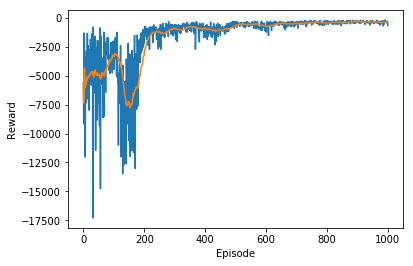

In [11]:
""" Implemented by Yinyu Jin """
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# avoid the warning message
gym.logger.set_level(40)

# hyperparameters
GAMMA = 0.99
learning_rate = 0.02
hidden_layer= 10
episodes = 1000

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size): 
        super (PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = F.softmax(self.fc2(x), dim=1)
        return x
        
    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        act_probs = self.forward(state)
        c = Categorical(act_probs)
        action = c.sample()
        
        log_prob = c.log_prob(action)
        action = action.item()
        return action, log_prob
    
    def update_policy(self, returns, log_probs): 
        policy_loss = []
        for log_prob, Gt in zip (log_probs, returns):
            policy_loss.append (-log_prob * Gt)
            
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        
        rewards = []
        log_probs = []
        
    def discounted_norm_rewards (self, rewards):
        returns = np.zeros_like(rewards)
        running_add = 0
        for t in reversed (range(len(rewards))):
            running_add = running_add * GAMMA + rewards[t]
            returns[t] = running_add
            
        #normalized discounted rewards
        returns = (returns - np.mean(returns)) / (np.std(returns)+eps)
        return returns
    

env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(1)

np.random.seed(1)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()

all_rewards = []
running_rewards = []


policy_net = PolicyNetwork(state_space,action_space, hidden_layer)

for episode in range(episodes): 
    state = env.reset()
    rewards = []
    log_probs = []
    
    while True:
        action, log_prob = policy_net.choose_action(state)
        new_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        
        if done: 
            returns = policy_net.discounted_norm_rewards(rewards)
            policy_net.update_policy(returns, log_probs)
            all_rewards.append(np.sum(rewards))
            running_rewards.append(np.mean(all_rewards[-30:]))
            if episode % 100 ==0:
                print('episode:', episode, 'total reward: ', all_rewards[-1], 'running reward:', int(running_rewards[-1]))
                
            break
        state = new_state
        
plt.plot(all_rewards)
plt.plot(running_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Actor-Critic


Episode: 0 Total reward:  -10000.0 Running reward: -10000
Episode: 100 Total reward:  -911.0 Running reward: -2061
Episode: 200 Total reward:  -302.0 Running reward: -952
Episode: 300 Total reward:  -474.0 Running reward: -527
Episode: 400 Total reward:  -282.0 Running reward: -348
Episode: 500 Total reward:  -527.0 Running reward: -395
Episode: 600 Total reward:  -222.0 Running reward: -257
Episode: 700 Total reward:  -174.0 Running reward: -233
Episode: 800 Total reward:  -281.0 Running reward: -265
Episode: 900 Total reward:  -164.0 Running reward: -191
Episode: 1000 Total reward:  -249.0 Running reward: -207


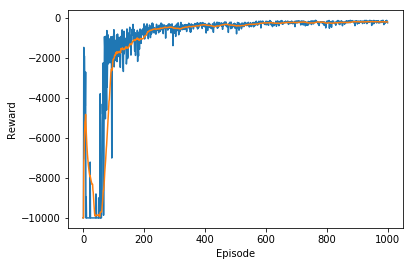

In [12]:
"""Inspiered by https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py"""

import gym
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# avoid the warning message
gym.logger.set_level(40)

# hyperparameters
GAMMA = 0.99
learning_rate = 0.02
hidden_layer= 50  
episodes = 1001

env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(0)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_space, hidden_layer)

        # actor's layer
        self.action_fc2 = nn.Linear(hidden_layer, action_space)

        # critic's layer
        self.value_fc2 = nn.Linear(hidden_layer, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.fc1(x))

        # actor: choses action to take from state s_t by returning probability of each action
        action_prob = F.softmax(self.action_fc2(x), dim=-1)

        # critic: evaluates state value
        state_values = self.value_fc2(x)

        # return values for both actor and critic as a tupel of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


model = Policy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take 
    return action.item()


def update_policy():
    """
    Training code. Calcultes actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


all_rewards = []
running_rewards = []

for i_episode in range(episodes):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 10000 steps so that we don't infinite loop while learning
    for t in range(10000):

        # select action from policy
        action = select_action(state)

        # take the action
        state, reward, done, _ = env.step(action)

        model.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    # update cumulative reward
    all_rewards.append(ep_reward)
    running_rewards.append(np.mean(all_rewards[-30:]))

    # perform backprop
    update_policy()

    # log results
    if i_episode % 100 == 0:
        print('Episode:', i_episode, 'Total reward: ', ep_reward, 'Running reward:', int(running_rewards[-1]))

plt.plot(all_rewards)
plt.plot(running_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()                